In [1]:
import pathlib
import os, sys
import numpy as np
from loguru import logger
from collections import defaultdict
from openset_imagenet.util import ccr_at_fpr
import openset_imagenet
from matplotlib import pyplot

In [2]:
def load_scores(args):
    # we sort them as follows: protocol, loss, algorithm
    scores = defaultdict(lambda: defaultdict(dict))
    ground_truths = {}
    for i in range (4, 127):
        for net in ["random", "hamming"]:
                score_file = f"bce_binary_ensemble_combined_emnist_test_arr_curr_{net}_{i}.npz"
                if os.path.exists(score_file):
                    # remember files
                    results = np.load(score_file)
                    scores[score_file] = results["scores"] # only change in maxlogits case

                    if len(ground_truths) == 0:
                        ground_truths = results["gt"].astype(int)
                    else:
                        assert np.all(results["gt"] == ground_truths)

                    logger.info(f"Loaded score file {score_file} for net {net}")
                else:
                    logger.warning(f"Did not find score file {score_file} for net {net}")

    return scores, ground_truths

In [3]:
THRESHOLDS = {
              1e-3: "$10^{-3}$",
              1e-2: "$10^{-2}$",
              1e-1: "$10^{-1}$",
              1: "$1$",
}

scores, ground_truths = load_scores(None)
random_ccrs = []
hamming_ccrs = []
# we get ccr@fpr for each network
for i in range (4, 127):
    for net in ["random", "hamming"]:
        full_net = f"bce_binary_ensemble_combined_emnist_test_arr_curr_{net}_{i}.npz"
        ccrs = ccr_at_fpr(ground_truths, scores[full_net], THRESHOLDS)
        ccrs_sum = 0
        for ccr in ccrs:
            if type(ccr) != type(None):
                ccrs_sum += ccr
        if net == "random":
            random_ccrs.append(ccrs_sum)
        else:
            hamming_ccrs.append(ccrs_sum)
        logger.info(f"Network {full_net}: {ccrs_sum} for thresholds {THRESHOLDS.values()}")

2024-05-30 18:14:48.498 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_random_4.npz for net random
2024-05-30 18:14:48.521 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_hamming_4.npz for net hamming
2024-05-30 18:14:48.536 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_random_5.npz for net random
2024-05-30 18:14:48.554 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_hamming_5.npz for net hamming
2024-05-30 18:14:48.574 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_random_6.npz for net random
2024-05-30 18:14:48.589 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_emnist_test_arr_curr_hamming_6.npz for net hamming
2024-05-30 18:14:48.608 | INFO     | __m

In [4]:
print(hamming_ccrs)
print(random_ccrs)

[2.2763999999999998, 2.2717, 2.2808, 2.2835, 2.283, 2.2861, 2.2764, 2.3131999999999997, 2.324, 2.3198, 2.3178, 2.3086, 2.3076, 2.3013, 2.2902, 2.2862, 2.2971, 2.2886, 2.3336, 2.3352, 2.3395, 2.3399, 2.3391, 2.3404000000000003, 2.3344, 2.3319, 2.3327, 2.3581, 2.3625, 2.364, 2.3593, 2.3695, 2.3669, 2.3704, 2.3674, 2.3639, 2.3594, 2.3561, 2.3644000000000003, 2.3929, 2.3931999999999998, 2.384, 2.3801, 2.3793, 2.3744, 2.3738, 2.3816, 2.3849, 2.3914, 2.3836, 2.3817999999999997, 2.3779, 2.377, 2.3705, 2.4153000000000002, 2.4146, 2.4129, 2.4127, 2.4119, 2.4107, 2.4116, 2.4146, 2.4119, 2.4128, 2.4092, 2.4077, 2.4097, 2.4097, 2.4069000000000003, 2.4191000000000003, 2.4293, 2.4273, 2.4335, 2.4323, 2.4318, 2.4297, 2.4277, 2.425, 2.4253, 2.4223, 2.4176, 2.4131, 2.4156999999999997, 2.4127, 2.4166, 2.4153000000000002, 2.4131, 2.4116, 2.4089, 2.4072999999999998, 2.4074999999999998, 2.4126, 2.4111, 2.402, 2.4253, 2.4232, 2.4266, 2.4263, 2.4127, 2.4238999999999997, 2.4084, 2.4217, 2.4207, 2.4204, 2.4204

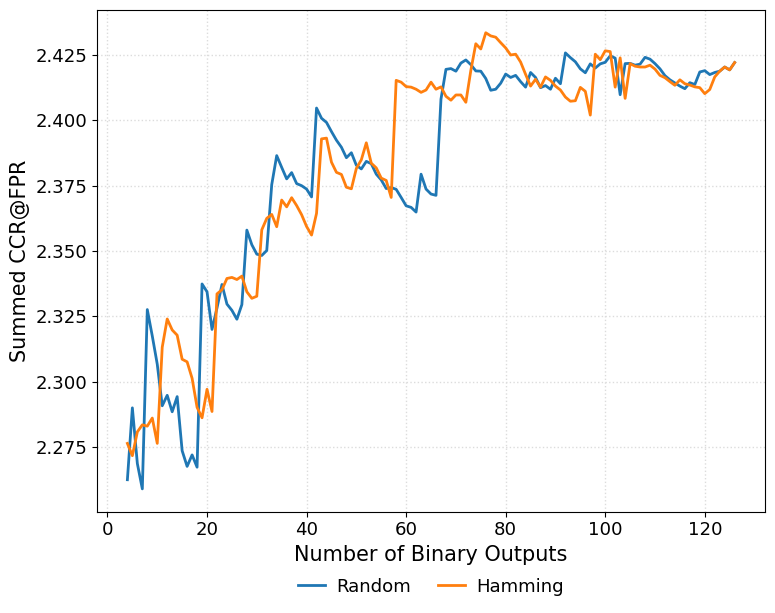

In [7]:
import matplotlib.pyplot as plt

# Set font properties
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15}
plt.rc('font', **font)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data
ax.plot(range(4, 127), random_ccrs, label="Random", linewidth=2)
ax.plot(range(4, 127), hamming_ccrs, label="Hamming", linewidth=2)

# Set axis labels
ax.set_xlabel('Number of Binary Outputs', fontsize=15)
ax.set_ylabel('Summed CCR@FPR', fontsize=15)

# Set y-axis range from 0 to 4
#ax.set_ylim(1.4, 1.6)

# Set grid properties
ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
ax.grid(axis='y', linestyle=':', linewidth=1, color='gainsboro')

# Set axis ticks
ax.tick_params(axis='both', which='major', labelsize=13)

# Adjust layout
plt.tight_layout()

# Set legend below the plot
plt.legend(frameon=False, fontsize=13, handlelength=1.5, handletextpad=0.6, columnspacing=1.5, loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=2)

# Display the plot
plt.savefig("ex_1_ccr_fpr.pdf", bbox_inches='tight')
plt.show()